This notebook aims to augment the already existing pre-trained word embeddings online which maybe GloVe, Word2Vec etc, which are generalized word embeddings together with the generated hate_speech_dataset which aims to leverage these existing word embeddings to generate new word embeddings for these new words in the hate_speech_dataset which may not Exist in the vocabulary of these word embeddings themselves

# Import Libraries

In [137]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import one_hot

from utilities.data_loaders import data_split_metric_values
from utilities.data_preprocessors import read_preprocess, shuffle_data, series_to_1D_array, construct_embedding_dict, construct_embedding_matrix
from utilities.data_visualizers import train_cross_results_v2, view_final_metrics, multi_class_heatmap, view_metric_values
from models.model_arcs import load_lstm_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# 1 for religious and 0 for non religious
df = pd.read_csv('./data/hate-speech-data-cleaned.csv', index_col=0)
df = shuffle_data(read_preprocess(df))

df['label'].value_counts()

2    22395
1    21644
0    19743
3     1998
Name: label, dtype: int64

In [139]:
all_words = pd.Series(series_to_1D_array(df['comment']))
all_unique_words_counts = all_words.value_counts()
all_unique_words = all_words.unique()

In [140]:
len(all_words)

894878

In [141]:
len(all_unique_words)

47921

In [142]:
all_unique_words_counts

nigger      16186
faggot      14812
bitch       12246
tranny      11850
like        11657
            ...  
cathol          1
dopeman         1
twinkish        1
rnegroes        1
rtruetbh        1
Length: 47921, dtype: int64

In [143]:
# before joining again get array in df with longest length first
max_len_1 = len(max(df['comment'], key=len))
type(max_len_1)

int

In [144]:
max_len_1

503

# Details about the dataframe
in summary classes are now to be the ff:
- NEITHER 1
- OFFENSIVE 0
- HATE 2
- HOMONYM 3

In [145]:
df['comment'] = df['comment'].apply(lambda comment: " ".join(comment))
df

,comment,label
0,call mexican asian black people standing line ...,2
1,fucking real retard holy fuck read tweet fucktard,0
2,thanks go clean trash ya lil nasty lol,1
3,depends im black area live isnt ghetto predomi...,2
4,hoe smash one yo nigga proud,0
...,...,...
65775,crazy hoe ken folk im talking friend family,0
65776,stop scared choke sex u bitch as nigga shell l...,0
65777,well title say political correctness transgend...,1
65778,fuck spear chucker,2


In [146]:
df.loc[0, 'comment']

'call mexican asian black people standing line lawn sprinkler spic spic spic spic chink nigger nigger nigger'

In [147]:
df['label'].value_counts()

2    22395
1    21644
0    19743
3     1998
Name: label, dtype: int64

# Preparing data for training classifier
**A note on the subsequent code below**

fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

In [148]:
sents = df['comment']
max_len_2 = 50

num_words_1 = df.shape[0]
num_words_2 = len(all_words)
num_words_3 = len(all_unique_words)

tokenizer = Tokenizer(num_words=num_words_3, split=' ')
tokenizer.fit_on_texts(sents)
# the bug is here that's why there are wrong indeces

seqs = tokenizer.texts_to_sequences(sents)

# post means place padding of 0's on the tail or ending of the sequence
# and truncating removes the values of a sequence that is greater than the max length given
seqs_padded = pad_sequences(seqs, maxlen=max_len_2, padding='post', truncating='post')

In [149]:
# at the same time one hot encode the y labels/classes
# and retrieve the number of unique labels of y
unique_labels = df['label'].unique()
len_unique_labels = len(unique_labels)
Y_oh = one_hot(df['label'], len_unique_labels).numpy()
Y_oh

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [150]:
seqs

[[19,
  975,
  485,
  14,
  6,
  1574,
  251,
  3887,
  15991,
  1126,
  1126,
  1126,
  1126,
  927,
  1,
  1,
  1],
 [18, 80, 317, 609, 12, 206, 459, 6270],
 [314, 29, 1141, 93, 202, 424, 1007, 55],
 [1394,
  84,
  14,
  918,
  185,
  665,
  411,
  9038,
  14,
  575,
  1211,
  4007,
  304,
  1,
  3483,
  14,
  6,
  94,
  27,
  4443,
  28,
  145,
  8,
  267,
  185,
  411,
  1926,
  575,
  1234,
  9,
  37,
  10,
  14,
  91,
  242,
  12,
  624,
  20,
  14,
  56,
  69,
  14,
  56],
 [13, 2992, 11, 175, 37, 856],
 [49, 3, 1701],
 [788, 379, 24, 3258, 4612, 941, 4798, 13],
 [3484, 48, 3484, 3484, 5, 119, 21627, 24, 58, 60, 32, 282, 2128],
 [37, 354, 2851, 4008, 3],
 [89, 1, 431, 25, 150, 1092, 78, 13072, 32, 2616],
 [143, 1, 21628, 719, 9989, 107],
 [101, 33, 31, 19, 4, 10, 1591, 99, 612, 21629],
 [8250, 2787, 1008, 1],
 [75, 21, 99, 1242, 1422, 2129, 239, 42, 25, 122, 41, 100, 341],
 [3, 7121, 389, 5],
 [112, 1641, 4, 369],
 [200, 76, 937, 182, 5711, 3, 720],
 [274, 13, 223, 696],
 [235, 

Here we see that indeed 50 is not enough as our max length but for the subsequent code we will still use 50 and later 503 for our experimentation. For now 503 will be an extremely large value eespecially when applied to all sequences

In [151]:
print(max_len_1, max_len_2)

503 50


In [152]:
word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word
print(len(word_to_index))

47916


In [153]:
word_to_index

{'nigger': 1,
 'faggot': 2,
 'bitch': 3,
 'tranny': 4,
 'like': 5,
 'people': 6,
 'would': 7,
 'get': 8,
 'word': 9,
 'say': 10,
 'one': 11,
 'fuck': 12,
 'hoe': 13,
 'black': 14,
 'shit': 15,
 'know': 16,
 'think': 17,
 'fucking': 18,
 'call': 19,
 'time': 20,
 'guy': 21,
 'make': 22,
 'white': 23,
 'got': 24,
 'gay': 25,
 'u': 26,
 'want': 27,
 'even': 28,
 'go': 29,
 'called': 30,
 'someone': 31,
 'really': 32,
 'thing': 33,
 'said': 34,
 'pussy': 35,
 'as': 36,
 'nigga': 37,
 'use': 38,
 'look': 39,
 'right': 40,
 'trannies': 41,
 'woman': 42,
 'see': 43,
 'saying': 44,
 'racist': 45,
 'man': 46,
 'way': 47,
 'cannot': 48,
 'good': 49,
 'calling': 50,
 'mean': 51,
 'still': 52,
 'never': 53,
 'also': 54,
 'lol': 55,
 'person': 56,
 'hate': 57,
 'much': 58,
 'need': 59,
 'could': 60,
 'going': 61,
 'used': 62,
 'love': 63,
 'back': 64,
 'year': 65,
 'day': 66,
 'girl': 67,
 'something': 68,
 'well': 69,
 'op': 70,
 'friend': 71,
 'bad': 72,
 'every': 73,
 'let': 74,
 'actually': 75,

In [154]:
index_to_word

{1: 'nigger',
 2: 'faggot',
 3: 'bitch',
 4: 'tranny',
 5: 'like',
 6: 'people',
 7: 'would',
 8: 'get',
 9: 'word',
 10: 'say',
 11: 'one',
 12: 'fuck',
 13: 'hoe',
 14: 'black',
 15: 'shit',
 16: 'know',
 17: 'think',
 18: 'fucking',
 19: 'call',
 20: 'time',
 21: 'guy',
 22: 'make',
 23: 'white',
 24: 'got',
 25: 'gay',
 26: 'u',
 27: 'want',
 28: 'even',
 29: 'go',
 30: 'called',
 31: 'someone',
 32: 'really',
 33: 'thing',
 34: 'said',
 35: 'pussy',
 36: 'as',
 37: 'nigga',
 38: 'use',
 39: 'look',
 40: 'right',
 41: 'trannies',
 42: 'woman',
 43: 'see',
 44: 'saying',
 45: 'racist',
 46: 'man',
 47: 'way',
 48: 'cannot',
 49: 'good',
 50: 'calling',
 51: 'mean',
 52: 'still',
 53: 'never',
 54: 'also',
 55: 'lol',
 56: 'person',
 57: 'hate',
 58: 'much',
 59: 'need',
 60: 'could',
 61: 'going',
 62: 'used',
 63: 'love',
 64: 'back',
 65: 'year',
 66: 'day',
 67: 'girl',
 68: 'something',
 69: 'well',
 70: 'op',
 71: 'friend',
 72: 'bad',
 73: 'every',
 74: 'let',
 75: 'actually',

In [155]:
seqs[0]

[19,
 975,
 485,
 14,
 6,
 1574,
 251,
 3887,
 15991,
 1126,
 1126,
 1126,
 1126,
 927,
 1,
 1,
 1]

In [156]:
# this is supposed to be 1301
print(word_to_index['complain'])

# this is supposed to be 3583
print(word_to_index['cleaning'])

1311
3677


In [157]:
seqs_padded

array([[  19,  975,  485, ...,    0,    0,    0],
       [  18,   80,  317, ...,    0,    0,    0],
       [ 314,   29, 1141, ...,    0,    0,    0],
       ...,
       [  69,  705,   10, ...,    0,    0,    0],
       [  12, 5414, 9011, ...,    0,    0,    0],
       [1554, 7376,   79, ...,    0,    0,    0]])

In [158]:
train_seqs, _seqs, train_labels, _labels = train_test_split(seqs_padded, Y_oh, test_size=0.3, random_state=0)
val_seqs, test_seqs, val_labels, test_labels = train_test_split(_seqs, _labels, test_size=0.5, random_state=0)

train_seqs

array([[  113,   158,     1, ...,     0,     0,     0],
       [19841,  5544,   170, ...,     0,     0,     0],
       [ 2274,  5353,   144, ...,     0,     0,     0],
       ...,
       [    2,   153,     0, ...,     0,     0,     0],
       [ 3862,   777,  1124, ...,     0,     0,     0],
       [ 3970,   113,    39, ...,     0,     0,     0]])

In [159]:
train_seqs.shape

(46046, 50)

In [160]:
val_seqs

array([[19865,     8,     3, ...,     0,     0,     0],
       [  291,    35,     0, ...,     0,     0,     0],
       [   57,   473,   110, ...,     0,     0,     0],
       ...,
       [    7,   396,   192, ...,     0,     0,     0],
       [    3,     0,     0, ...,     0,     0,     0],
       [ 1675,  3695,    35, ...,     0,     0,     0]])

In [161]:
len(val_seqs)

9867

# Loading the Big Guns 
or the 1.9 million word vocabulary and its 300 dimensional embeddings

In [162]:
# important variables

# includes oov words
vocab_len = len(word_to_index) + 1
emb_dict, emb_vec_len = construct_embedding_dict('./embeddings/glove.42B.300d.txt', word_to_index)
emb_matrix = construct_embedding_matrix(word_to_index, emb_dict, emb_vec_len)
lstm_model = load_lstm_model(max_len_2, vocab_len, emb_matrix)

100%|██████████| 47916/47916 [00:00<00:00, 240931.28it/s]


input shape: 50


In [163]:
lstm_model.summary()

Model: "hate-speech-lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 300)           14375100  
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 32)           40576     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 50, 32)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 32)           

In [164]:
len(emb_dict)

36132

In [165]:
emb_matrix.shape

(47917, 300)

In [166]:
lstm_history = lstm_model.fit(
    train_seqs, train_labels,
    batch_size=128,
    epochs=10,
    validation_data=(val_seqs, val_labels),
)

# build the dictionary of results based on metric history of both models
lstm_results = {}
for metric in ['loss', 'categorical_crossentropy', 'categorical_accuracy', 'val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy']:
    if metric not in lstm_results:
        lstm_results[metric] = lstm_history.history[metric]

Epoch 1/10
360/360 [==============================] - 50s 112ms/step - loss: 0.7121 - categorical_crossentropy: 0.7121 - categorical_accuracy: 0.7151 - val_loss: 0.4989 - val_categorical_crossentropy: 0.4989 - val_categorical_accuracy: 0.8142
Epoch 2/10
360/360 [==============================] - 35s 98ms/step - loss: 0.5187 - categorical_crossentropy: 0.5187 - categorical_accuracy: 0.8167 - val_loss: 0.4712 - val_categorical_crossentropy: 0.4712 - val_categorical_accuracy: 0.8253
Epoch 3/10
360/360 [==============================] - 36s 100ms/step - loss: 0.4828 - categorical_crossentropy: 0.4828 - categorical_accuracy: 0.8324 - val_loss: 0.4660 - val_categorical_crossentropy: 0.4660 - val_categorical_accuracy: 0.8282
Epoch 4/10
360/360 [==============================] - 35s 97ms/step - loss: 0.4576 - categorical_crossentropy: 0.4576 - categorical_accuracy: 0.8431 - val_loss: 0.4462 - val_categorical_crossentropy: 0.4462 - val_categorical_accuracy: 0.8364
Epoch 5/10
360/360 [==========

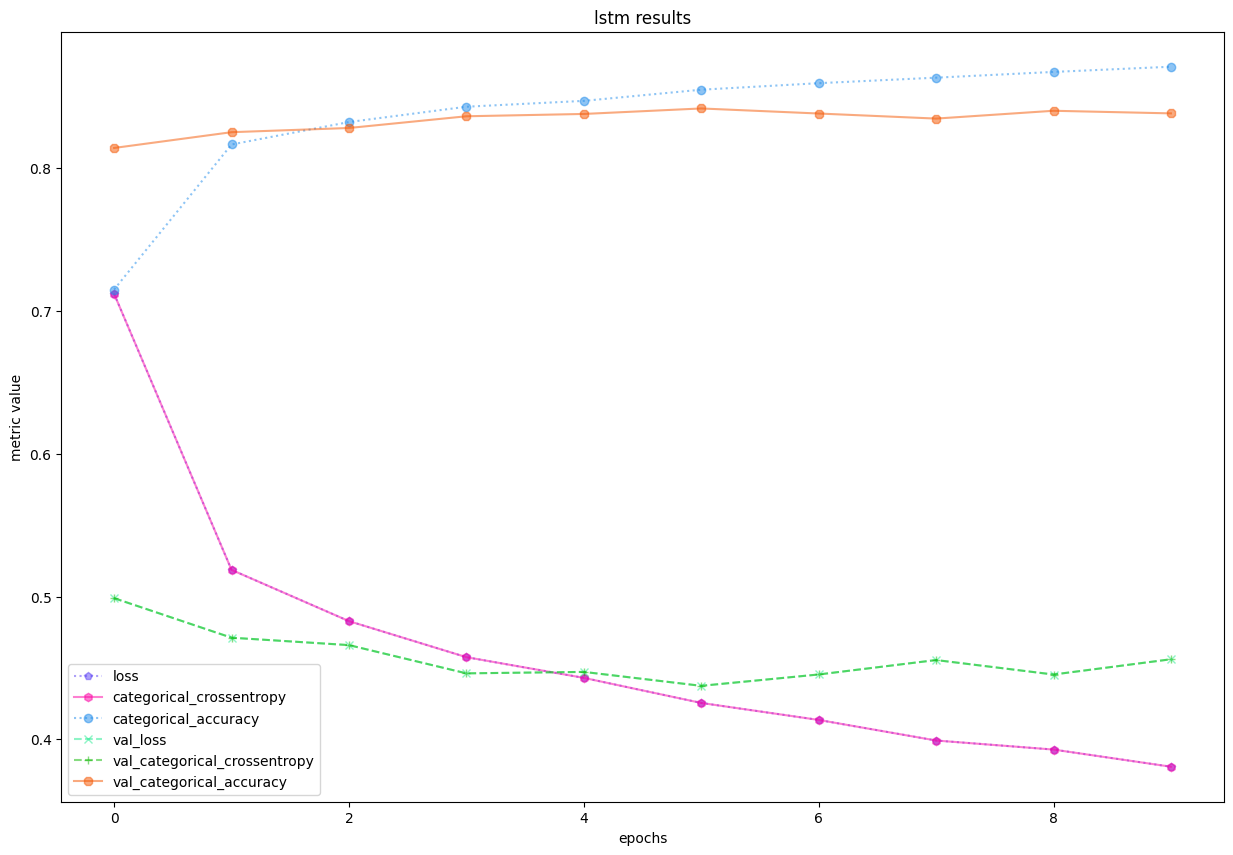

In [167]:
train_cross_results_v2(lstm_results, epochs=lstm_history.epoch, img_title='lstm results')

In [168]:
# display values from last epoch of baseline model
view_final_metrics(lstm_results, 'LSTM NEURAL NETWORK RESULTS')


LSTM NEURAL NETWORK RESULTS:
loss: 0.380841463804245
categorical_crossentropy: 0.380841463804245
categorical_accuracy: 0.8711288571357727
val_loss: 0.4561060965061188
val_categorical_crossentropy: 0.4561060965061188
val_categorical_accuracy: 0.8384513854980469


# Calculating main metric values for training, validation, and testing set e.g. Accuracy, Precision, Recall, F1-Score

In [169]:
# predict probabilities for training set
Y_pred_train = lstm_model.predict(train_seqs).argmax(axis=1)
Y_true_train = train_labels.argmax(axis=1)

# predict probabilities for validation set
Y_pred_val = lstm_model.predict(val_seqs).argmax(axis=1)
Y_true_val = val_labels.argmax(axis=1)

# predict probabilities for testing set
Y_pred_test = lstm_model.predict(test_seqs).argmax(axis=1)
Y_true_test = test_labels.argmax(axis=1)

309/309 [==============================] - 6s 21ms/step


In [170]:
# calculate accuracy, precision, recall, and f1-score for every data split
train_acc, train_prec, train_rec, train_f1 = data_split_metric_values(Y_true_train, Y_pred_train)
val_acc, val_prec, val_rec, val_f1 = data_split_metric_values(Y_true_val, Y_pred_val)
test_acc, test_prec, test_rec, test_f1 = data_split_metric_values(Y_true_test, Y_pred_test)

metrics_df = pd.DataFrame({
    'data_split': ['training', 'validation', 'testing'],
    'accuracy': [train_acc, val_acc, test_acc], 
    'precision': [train_prec, val_prec, test_prec], 
    'recall': [train_rec, val_rec, test_rec], 
    'f1-score': [train_f1, val_f1, test_f1]})

Accuracy: 88.46%
Precision: 88.55%
Recall: 88.46%
F1 score: 88.50%

Accuracy: 83.85%
Precision: 83.93%
Recall: 83.85%
F1 score: 83.88%

Accuracy: 83.34%
Precision: 83.44%
Recall: 83.34%
F1 score: 83.38%



FileNotFoundError: [Errno 2] No such file or directory: './images & figures/lstm classifier metric values.png'

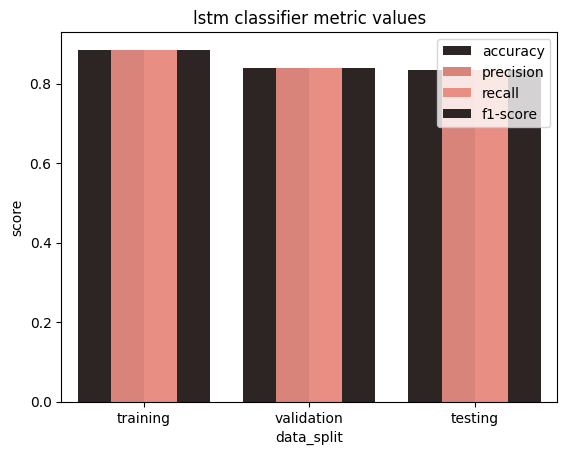

In [171]:
# visualize values of calculated metric value for each data split
view_metric_values(metrics_df, 'lstm classifier metric values', cmap='dark:salmon_r')

# Confusion matrices for training, validation, and testing sets

In [ ]:
conf_matrix_train = confusion_matrix(Y_true_train, Y_pred_train, labels=np.unique(Y_true_train))
multi_class_heatmap(conf_matrix_train, 'softmax classifier training set confusion matrix', cmap='flare')

In [ ]:
conf_matrix_val = confusion_matrix(Y_true_val, Y_pred_val, labels=np.unique(Y_true_val))
multi_class_heatmap(conf_matrix_val, 'softmax classifier validation set confusion matrix', cmap='flare')

In [ ]:
conf_matrix_test = confusion_matrix(Y_true_test, Y_pred_test, labels=np.unique(Y_true_test))
multi_class_heatmap(conf_matrix_test, 'softmax classifier testing set confusion matrix', cmap='flare')